In [ ]:
# imports 
import os
import numpy as np
import pandas as pd
from glob import glob
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from bct.algorithms import clustering_coef_wu, efficiency_wei
warnings.filterwarnings('ignore')
from statsmodels.stats.multitest import multipletests

# set matplotlib and seaborn parameters for consistent figures and to be able to edit pdf text as in illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
sns.set_context("notebook", font_scale=1.5)

## load the matrices

In [17]:
# define data locations for each matrix type
folders = {
    'pearson': '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/pearson_matrices',
    'fisher': '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/fisher_matrices'
}

# specify time points to process (file name end with this)
time_points = ['PND30', 'PND90']

# create dicts to store matrices and subject ids for each type and time point
cleaned_matrices_pearson = {}
cleaned_matrices_fisher = {}
subject_ids_pearson = {}
subject_ids_fisher = {}

# loop over time points
for tp in time_points:
    files_pearson = glob(os.path.join(folders['pearson'], f"*{tp}*.csv"))
    files_fisher = glob(os.path.join(folders['fisher'], f"*{tp}*.csv"))
    cleaned_matrices_pearson[tp] = [pd.read_csv(file) for file in files_pearson]
    cleaned_matrices_fisher[tp] = [pd.read_csv(file) for file in files_fisher]
    subject_ids_pearson[tp] = [os.path.basename(f).split('_')[0] for f in files_pearson]
    subject_ids_fisher[tp] = [os.path.basename(f).split('_')[0] for f in files_fisher]


In [18]:
# load the genotype information
gens_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/Cohort1_demographics.xlsx'
gens = pd.read_excel(gens_path)

# initialize dictionaries for genotypes, matched to each time point
genotypes_pearson = {}
genotypes_fisher = {}

# loop through each time point to collect genotypes by subject id
for tp in ['PND30', 'PND90']:
    # for pearson matrices
    gt_pearson = []
    for sid in subject_ids_pearson[tp]:
        g = gens[gens['Animal_ID'] == sid]['Genotype'].values
        gt_pearson.append(g[0] if len(g) > 0 else 'NA')
    genotypes_pearson[tp] = gt_pearson
    # for fisher matrices
    gt_fisher = []
    for sid in subject_ids_fisher[tp]:
        g = gens[gens['Animal_ID'] == sid]['Genotype'].values
        gt_fisher.append(g[0] if len(g) > 0 else 'NA')
    genotypes_fisher[tp] = gt_fisher


In [19]:
# define exclusions as a dict for each time point, these scans were excluded due to lack of componenents on the PCA or suboptimal registration/scan quality
exclude_animals = {
    'PND30': ['COMR332f', 'COMR332d', 'COMR311h', 'COMR302c', 'COMR381e'],
    'PND90': ['COMR431c', 'COMR311h', 'COMR381g']
}

def exclude_by_indices(seq, indices):
    # return items not at indices
    return [item for i, item in enumerate(seq) if i not in indices]

# create new dicts for excluded data
excluded_matrices_pearson = {}
excluded_genotypes_pearson = {}
excluded_subject_ids_pearson = {}

excluded_matrices_fisher = {}
excluded_genotypes_fisher = {}
excluded_subject_ids_fisher = {}

# loop through each time point
for tp in ['PND30', 'PND90']:
    # get indices to exclude for pearson type
    indices_pearson = [i for i, sid in enumerate(subject_ids_pearson[tp]) if sid in exclude_animals[tp]]
    # exclude from matrices, genotypes, subject ids
    excluded_matrices_pearson[tp] = exclude_by_indices(cleaned_matrices_pearson[tp], indices_pearson)
    excluded_genotypes_pearson[tp] = exclude_by_indices(genotypes_pearson[tp], indices_pearson)
    excluded_subject_ids_pearson[tp] = exclude_by_indices(subject_ids_pearson[tp], indices_pearson)
    
    # repeat for fisher type
    indices_fisher = [i for i, sid in enumerate(subject_ids_fisher[tp]) if sid in exclude_animals[tp]]
    excluded_matrices_fisher[tp] = exclude_by_indices(cleaned_matrices_fisher[tp], indices_fisher)
    excluded_genotypes_fisher[tp] = exclude_by_indices(genotypes_fisher[tp], indices_fisher)
    excluded_subject_ids_fisher[tp] = exclude_by_indices(subject_ids_fisher[tp], indices_fisher)


In [20]:
# define desired roi order
desired_roi_order = [ 'R_brain_stem', 'R_colliculus', 'R_pag',
    'R_ventral_hippocampus', 'R_dorsal_hippocampus', 'R_midbrain',
    'R_thalamus', 'R_hypothalamus', 'R_septum', 'R_striatum',
    'R_pallidum_acc', 'R_entorhinal_cx', 'R_amygdala', 'R_sensory_cx',
    'R_cingulate_cx', 'R_motor_cx', 'R_prefrontal_cx', 'R_olfactory',
    'L_olfactory', 'L_prefrontal_cx', 'L_motor_cx', 'L_cingulate_cx',
    'L_sensory_cx', 'L_amygdala', 'L_entorhinal_cx', 'L_pallidum_acc',
    'L_striatum', 'L_septum', 'L_hypothalamus', 'L_thalamus', 'L_midbrain',
    'L_dorsal_hippocampus', 'L_ventral_hippocampus', 'L_pag',
    'L_colliculus', 'L_brain_stem',
]

# function to reorder both columns and rows by roi order
def reorder_matrix_by_column_order(matrices, roi_order):
    reordered = []
    for mat in matrices:
        idxs = [mat.columns.get_loc(roi) for roi in roi_order]
        sorted_mat = mat.iloc[idxs, idxs]
        reordered.append(sorted_mat)
    return reordered

# prepare output dictionaries keyed by time point
reordered_matrices_pearson = {}
reordered_matrices_fisher = {}
ko_matrices_pearson = {}
wt_matrices_pearson = {}
ko_matrices_fisher = {}
wt_matrices_fisher = {}

# repeat the following operations for each time point
for tp in ['PND30', 'PND90']:
    # roi check
    roi_names = list(excluded_matrices_pearson[tp][0].columns)
    missing_rois = [roi for roi in desired_roi_order if roi not in roi_names]
    if missing_rois:
        print('warning:', tp, 'these rois not found in', missing_rois)
    # reorder pearson and fisher matrices
    reordered_matrices_pearson[tp] = reorder_matrix_by_column_order(excluded_matrices_pearson[tp], desired_roi_order)
    reordered_matrices_fisher[tp] = reorder_matrix_by_column_order(excluded_matrices_fisher[tp], desired_roi_order)
    # split by genotype
    ko_matrices_pearson[tp] = [mat for mat, gen in zip(reordered_matrices_pearson[tp], excluded_genotypes_pearson[tp]) if gen.strip().upper() == 'KO']
    wt_matrices_pearson[tp] = [mat for mat, gen in zip(reordered_matrices_pearson[tp], excluded_genotypes_pearson[tp]) if gen.strip().upper() == 'WT']
    ko_matrices_fisher[tp] = [mat for mat, gen in zip(reordered_matrices_fisher[tp], excluded_genotypes_fisher[tp]) if gen.strip().upper() == 'KO']
    wt_matrices_fisher[tp] = [mat for mat, gen in zip(reordered_matrices_fisher[tp], excluded_genotypes_fisher[tp]) if gen.strip().upper() == 'WT']


In [21]:
# access the first pearson ko matrix for pnd30
ko_matrices_pearson['PND30'][0]


,R_brain_stem,R_colliculus,R_pag,R_ventral_hippocampus,R_dorsal_hippocampus,R_midbrain,R_thalamus,R_hypothalamus,R_septum,R_striatum,...,L_striatum,L_septum,L_hypothalamus,L_thalamus,L_midbrain,L_dorsal_hippocampus,L_ventral_hippocampus,L_pag,L_colliculus,L_brain_stem
18,0.000000,0.573031,0.566503,0.386815,0.466272,0.625862,0.414532,0.381679,0.374929,0.429650,...,0.513015,0.408689,0.454626,0.512327,0.598311,0.536111,0.483165,0.495028,0.541819,0.638692
19,0.573031,0.000000,0.882328,0.542031,0.863065,0.906759,0.831244,0.664175,0.640406,0.746170,...,0.847364,0.667757,0.718867,0.857265,0.858118,0.887916,0.776727,0.796480,0.927031,0.423533
20,0.566503,0.882328,0.000000,0.492739,0.777799,0.900973,0.770386,0.595139,0.546550,0.693010,...,0.796414,0.586301,0.681201,0.847163,0.879259,0.818478,0.745509,0.907081,0.885620,0.427917
21,0.386815,0.542031,0.492739,0.000000,0.585066,0.579150,0.502972,0.419447,0.384887,0.453236,...,0.522056,0.404500,0.425248,0.490361,0.487118,0.536495,0.501508,0.496436,0.506384,0.209364
22,0.466272,0.863065,0.777799,0.585066,0.000000,0.816701,0.882582,0.685694,0.714606,0.745977,...,0.837573,0.729312,0.730932,0.856634,0.794871,0.934946,0.790932,0.770450,0.848354,0.313004
23,0.625862,0.906759,0.900973,0.579150,0.816701,0.000000,0.825151,0.633235,0.592072,0.725598,...,0.828070,0.613257,0.697689,0.860805,0.873594,0.846107,0.767906,0.807799,0.886634,0.431592
24,0.414532,0.831244,0.770386,0.502972,0.882582,0.825151,0.000000,0.714143,0.712114,0.756962,...,0.833634,0.739449,0.721026,0.856236,0.799079,0.877920,0.753886,0.751978,0.842274,0.334159
25,0.381679,0.664175,0.595139,0.419447,0.685694,0.633235,0.714143,0.000000,0.727408,0.619420,...,0.685433,0.701708,0.791631,0.698566,0.655606,0.721077,0.613450,0.581710,0.667153,0.285556
26,0.374929,0.640406,0.546550,0.384887,0.714606,0.592072,0.712114,0.727408,0.000000,0.702414,...,0.719798,0.921833,0.705333,0.701904,0.603163,0.750117,0.581249,0.563754,0.658063,0.263728
27,0.429650,0.746170,0.693010,0.453236,0.745977,0.725598,0.756962,0.619420,0.702414,0.000000,...,0.856518,0.644826,0.614600,0.737597,0.685206,0.755393,0.596042,0.654783,0.771528,0.293047


# calculate FC sparsities

In [22]:
def threshold_matrix(matrix, density):
    """
    thresholds a matrix to retain only the top 'density%' of strongest connections.

    args:
        matrix (np.ndarray): input connectivity matrix.
        density (float): sparsity level (percentage of edges to retain).

    returns:
        np.ndarray: thresholded matrix.
    """
    flat_matrix = matrix.flatten()
    sorted_edges = np.sort(flat_matrix)[::-1]  # sort descending

    n_edges = int(len(sorted_edges) * density / 100)
    # avoid zero or negative index
    if n_edges == 0:
        threshold_value = sorted_edges[0]
    else:
        threshold_value = sorted_edges[n_edges - 1]

    thresholded_matrix = np.where(matrix >= threshold_value, matrix, 0)
    return thresholded_matrix

densities = range(5, 55, 5)  # 5, 10, ..., 50

for tp in ['PND30', 'PND90']:
    # create a results dataframe using filtered ids for this cohort/time point
    results_df = pd.DataFrame({'ID': excluded_subject_ids_fisher[tp]})

    for density in densities:
        fc_values = []
        # note that this uses fisher matrices
        for matrix in excluded_matrices_fisher[tp]:
            matrix_array = matrix.to_numpy()
            thresholded_matrix = threshold_matrix(matrix_array, density)
            non_zero_values = thresholded_matrix[thresholded_matrix != 0]
            if non_zero_values.size == 0:
                fc = np.nan
            else:
                fc = np.mean(np.abs(non_zero_values))
            fc_values.append(fc)
        results_df[f'Sparsity_{density}'] = fc_values

    # save 
    results_df.to_excel(f'/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_fc_{tp}.xlsx', index=False)
    print(f'saved results for {tp}')
    print(results_df.head(2))


saved results for PND30
         ID  Sparsity_5  Sparsity_10  Sparsity_15  Sparsity_20  Sparsity_25  \
0  COMR291i    0.715883     0.620903     0.567103     0.527140     0.495155   
1  COMR232e    0.581397     0.489071     0.436756     0.399602     0.370664   

   Sparsity_30  Sparsity_35  Sparsity_40  Sparsity_45  Sparsity_50  
0     0.467941     0.443633     0.423365     0.404862     0.387647  
1     0.346561     0.325055     0.307079     0.291009     0.276768  
saved results for PND90
         ID  Sparsity_5  Sparsity_10  Sparsity_15  Sparsity_20  Sparsity_25  \
0  COMR332d    1.154576     1.035096     0.950897     0.884914     0.833492   
1  COMR232d    0.872353     0.740506     0.672216     0.623148     0.587414   

   Sparsity_30  Sparsity_35  Sparsity_40  Sparsity_45  Sparsity_50  
0     0.790413     0.751697     0.716247     0.680595     0.645095  
1     0.557109     0.531240     0.508785     0.487304     0.468074  


## calculate global efficiency sparsities

In [23]:
densities = range(5, 55, 5)  # 5, 10, ..., 50

# loop over both time points
for tp in ['PND30', 'PND90']:
    # create a results dataframe for this time point using filtered subject ids
    global_efficiency_df = pd.DataFrame({'ID': excluded_subject_ids_pearson[tp]})
    
    for density in densities:
        efficiency_values = []
        # note that this uses pearson matrices
        for matrix in excluded_matrices_pearson[tp]:
            matrix_array = matrix.to_numpy()
            thresholded_matrix = threshold_matrix(matrix_array, density)

            # nan if matrix is all zeros after thresholding
            if np.sum(np.abs(thresholded_matrix)) == 0:
                global_eff = np.nan
            else:
                try:
                    global_eff = efficiency_wei(thresholded_matrix)
                except Exception as e:
                    print('error at timepoint', tp, 'subject index', len(efficiency_values), 
                          'density', density, '->', str(e))
                    global_eff = np.nan

            efficiency_values.append(global_eff)
        global_efficiency_df[f'Sparsity_{density}'] = efficiency_values
    
    # save 
    global_efficiency_df.to_excel(f'/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_{tp}.xlsx', index=False)
    print(f'saved global efficiency results for {tp}')
    print(global_efficiency_df.head(2))


saved global efficiency results for PND30
         ID  Sparsity_5  Sparsity_10  Sparsity_15  Sparsity_20  Sparsity_25  \
0  COMR351a    0.069270     0.162566     0.243388     0.290700     0.314015   
1  COMR212c    0.104323     0.171663     0.226977     0.262083     0.289333   

   Sparsity_30  Sparsity_35  Sparsity_40  Sparsity_45  Sparsity_50  
0     0.334678     0.383461     0.413646     0.465499     0.490439  
1     0.297491     0.304970     0.309817     0.311172     0.312191  
saved global efficiency results for PND90
         ID  Sparsity_5  Sparsity_10  Sparsity_15  Sparsity_20  Sparsity_25  \
0  COMR212a    0.059071     0.150044     0.190132     0.238538     0.270662   
1  COMR232d    0.054572     0.168096     0.204525     0.256771     0.278369   

   Sparsity_30  Sparsity_35  Sparsity_40  Sparsity_45  Sparsity_50  
0     0.301762     0.311083     0.328188     0.334638     0.340159  
1     0.297312     0.306982     0.311778     0.315882     0.318064  


## calculate clustering coefficient sparsities

In [24]:
densities = range(5, 55, 5)

for tp in ['PND30', 'PND90']:
    # make a dataframe for this time point with filtered ids
    clustering_df = pd.DataFrame({'ID': excluded_subject_ids_pearson[tp]})

    for density in densities:
        clustering_values = []
        # note that this also uses pearson matrices
        for matrix in excluded_matrices_pearson[tp]:
            matrix_array = matrix.to_numpy()
            thresholded_matrix = threshold_matrix(matrix_array, density)
            # handle fully disconnected graphs
            if np.sum(np.abs(thresholded_matrix)) == 0:
                mean_clustering = np.nan
            else:
                try:
                    clustering_coefficients = clustering_coef_wu(thresholded_matrix)
                    mean_clustering = np.mean(clustering_coefficients)
                except Exception as e:
                    print('error at time point', tp, 'density', density, ':', str(e))
                    mean_clustering = np.nan
            clustering_values.append(mean_clustering)
        clustering_df[f'Sparsity_{density}'] = clustering_values

    # save
    clustering_df.to_excel(f'/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_{tp}.xlsx', index=False)
    print('saved clustering results for', tp)
    print(clustering_df.head(2))


saved clustering results for PND30
         ID  Sparsity_5  Sparsity_10  Sparsity_15  Sparsity_20  Sparsity_25  \
0  COMR351a    0.202877     0.307451     0.363590     0.414191     0.455988   
1  COMR212c    0.031891     0.151225     0.217966     0.249602     0.269943   

   Sparsity_30  Sparsity_35  Sparsity_40  Sparsity_45  Sparsity_50  
0     0.470876     0.518578     0.516820     0.530176     0.527787  
1     0.292321     0.321682     0.308911     0.317026     0.311426  
saved clustering results for PND90
         ID  Sparsity_5  Sparsity_10  Sparsity_15  Sparsity_20  Sparsity_25  \
0  COMR212a    0.176157     0.212480     0.251328     0.284971     0.298199   
1  COMR232d    0.171399     0.197723     0.297737     0.261507     0.268184   

   Sparsity_30  Sparsity_35  Sparsity_40  Sparsity_45  Sparsity_50  
0     0.325410     0.341549     0.350117     0.351591     0.350469  
1     0.279415     0.286634     0.325183     0.324661     0.327141  


## calculate efficiency and clustering for random networks

In [25]:
densities = range(5, 55, 5)
for tp in ['PND30', 'PND90']:
    results_eff_df = pd.DataFrame({'ID': excluded_subject_ids_pearson[tp]})
    results_clust_df = pd.DataFrame({'ID': excluded_subject_ids_pearson[tp]})
    
    for density in densities:
        rand_eff_values = []
        rand_clust_values = []
        for matrix in excluded_matrices_pearson[tp]:
            empirical = np.maximum(matrix.to_numpy(), matrix.to_numpy().T)
            # flatten the upper triangle and shuffle
            matrix_size = empirical.shape[0]
            triu_idx = np.triu_indices(matrix_size, k=1)
            values = empirical[triu_idx].copy()
            np.random.shuffle(values)
            # make new random symmetric matrix
            rand_matrix = np.zeros_like(empirical)
            rand_matrix[triu_idx] = values
            rand_matrix = rand_matrix + rand_matrix.T
            np.fill_diagonal(rand_matrix, 0)
            # threshold the random matrix
            thresholded = threshold_matrix(rand_matrix, density)
            thresholded = np.maximum(thresholded, thresholded.T)
            # metric calculation (nan guard)
            if np.sum(np.abs(thresholded)) == 0:
                rand_eff = np.nan
                rand_clust = np.nan
            else:
                rand_eff = efficiency_wei(thresholded)
                rand_clust = np.mean(clustering_coef_wu(thresholded))
            rand_eff_values.append(rand_eff)
            rand_clust_values.append(rand_clust)
        results_eff_df[f'Sparsity_{density}'] = rand_eff_values
        results_clust_df[f'Sparsity_{density}'] = rand_clust_values

    results_eff_df.to_excel(f'/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_null_shuffle_{tp}.xlsx', index=False)
    results_clust_df.to_excel(f'/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_null_shuffle_{tp}.xlsx', index=False)
    print(f'saved shuffled null results for {tp}')


saved shuffled null results for PND30
saved shuffled null results for PND90


# GT multiplot

In [ ]:
# read genotypes
gens_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/cohort1_demographics.xlsx'
gens = pd.read_excel(gens_path)
genotype_dict = dict(zip(gens['Animal_ID'], gens['Genotype']))

# read all the network measure files
fc_30 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_fc_PND30.xlsx')
fc_90 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_fc_PND90.xlsx')

clustering_30 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_PND30.xlsx')
clustering_90 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_PND90.xlsx')
rand_clustering_30 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_null_shuffle_PND30.xlsx')
rand_clustering_90 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_null_shuffle_PND90.xlsx')

efficiency_30 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_PND30.xlsx')
efficiency_90 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_PND90.xlsx')
rand_efficiency_30 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_null_shuffle_PND30.xlsx')
rand_efficiency_90 = pd.read_excel('/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_null_shuffle_PND90.xlsx')

In [27]:
# add genotype column to a dataframe
def add_genotype(df):
    df['Genotype'] = df['ID'].map(genotype_dict)
    return df

fc_30 = add_genotype(fc_30)
fc_90 = add_genotype(fc_90)
clustering_30 = add_genotype(clustering_30)
clustering_90 = add_genotype(clustering_90)
efficiency_30 = add_genotype(efficiency_30)
efficiency_90 = add_genotype(efficiency_90)

fc_30.head(1)

,ID,Sparsity_5,Sparsity_10,Sparsity_15,Sparsity_20,Sparsity_25,Sparsity_30,Sparsity_35,Sparsity_40,Sparsity_45,Sparsity_50,Genotype
0,COMR291i,0.715883,0.620903,0.567103,0.52714,0.495155,0.467941,0.443633,0.423365,0.404862,0.387647,KO


In [28]:
# create delta dataframe with only common IDs
def create_delta_df_common_ids(df_90, df_30):
    """
    calculate delta between two dataframes, using only common IDs.

    Args:
        df_90 (pd.DataFrame): Dataframe for 90-day data.
        df_30 (pd.DataFrame): Dataframe for 30-day data.

    Returns:
        pd.DataFrame: Delta dataframe with common IDs and Genotype column.
    """
    # align dataframes by ID
    aligned_90 = df_90.set_index('ID')
    aligned_30 = df_30.set_index('ID')

    # intersect IDs to ensure matching rows
    common_ids = aligned_90.index.intersection(aligned_30.index)
    aligned_90 = aligned_90.loc[common_ids]
    aligned_30 = aligned_30.loc[common_ids]

    # get sparsity columns
    sparsity_cols = [col for col in aligned_90.columns if 'Sparsity' in col]

    # calculate the delta for sparsity columns
    delta_df = aligned_90[sparsity_cols] - aligned_30[sparsity_cols]

    # add the Genotype column from aligned_90
    delta_df['Genotype'] = aligned_90['Genotype']

    # reset index to bring 'ID' back as a column
    delta_df.reset_index(inplace=True)

    return delta_df

fc_delta = create_delta_df_common_ids(fc_90, fc_30)
ge_delta = create_delta_df_common_ids(efficiency_90, efficiency_30)
cc_delta = create_delta_df_common_ids(clustering_90, clustering_30)
fc_delta.head(1)


,ID,Sparsity_5,Sparsity_10,Sparsity_15,Sparsity_20,Sparsity_25,Sparsity_30,Sparsity_35,Sparsity_40,Sparsity_45,Sparsity_50,Genotype
0,COMR232d,0.361365,0.305048,0.282557,0.267313,0.2567,0.247467,0.239587,0.231925,0.224093,0.217014,KO


In [30]:
missing_ids_in_30 = set(fc_90['ID']) - set(fc_30['ID'])
missing_ids_in_90 = set(fc_30['ID']) - set(fc_90['ID'])

print("IDs present at PND90 but not at PND30:", missing_ids_in_30)
print("IDs present at PND30 but not at PND90:", missing_ids_in_90)


IDs present at PND90 but not at PND30: {'COMR332d', 'COMR381e', 'COMR302c', 'COMR332f'}
IDs present at PND30 but not at PND90: {'COMR381g', 'COMR431d', 'COMR431c'}


In [31]:
#extract sparsity columns 

fc_30_sparsity_cols         = [col for col in fc_30.columns         if 'Sparsity' in col]
fc_90_sparsity_cols         = [col for col in fc_90.columns         if 'Sparsity' in col]
fc_delta_sparsity_cols      = [col for col in fc_delta.columns      if 'Sparsity' in col]

clustering_30_sparsity_cols = [col for col in clustering_30.columns if 'Sparsity' in col]
clustering_90_sparsity_cols = [col for col in clustering_90.columns if 'Sparsity' in col]
cc_delta_sparsity_cols      = [col for col in cc_delta.columns      if 'Sparsity' in col]

efficiency_30_sparsity_cols = [col for col in efficiency_30.columns if 'Sparsity' in col]
efficiency_90_sparsity_cols = [col for col in efficiency_90.columns if 'Sparsity' in col]
ge_delta_sparsity_cols      = [col for col in ge_delta.columns      if 'Sparsity' in col]

rand_clustering_30_sparsity_cols = [col for col in rand_clustering_30.columns if 'Sparsity' in col]
rand_clustering_90_sparsity_cols = [col for col in rand_clustering_90.columns if 'Sparsity' in col]
rand_efficiency_30_sparsity_cols = [col for col in rand_efficiency_30.columns if 'Sparsity' in col]
rand_efficiency_90_sparsity_cols = [col for col in rand_efficiency_90.columns if 'Sparsity' in col]

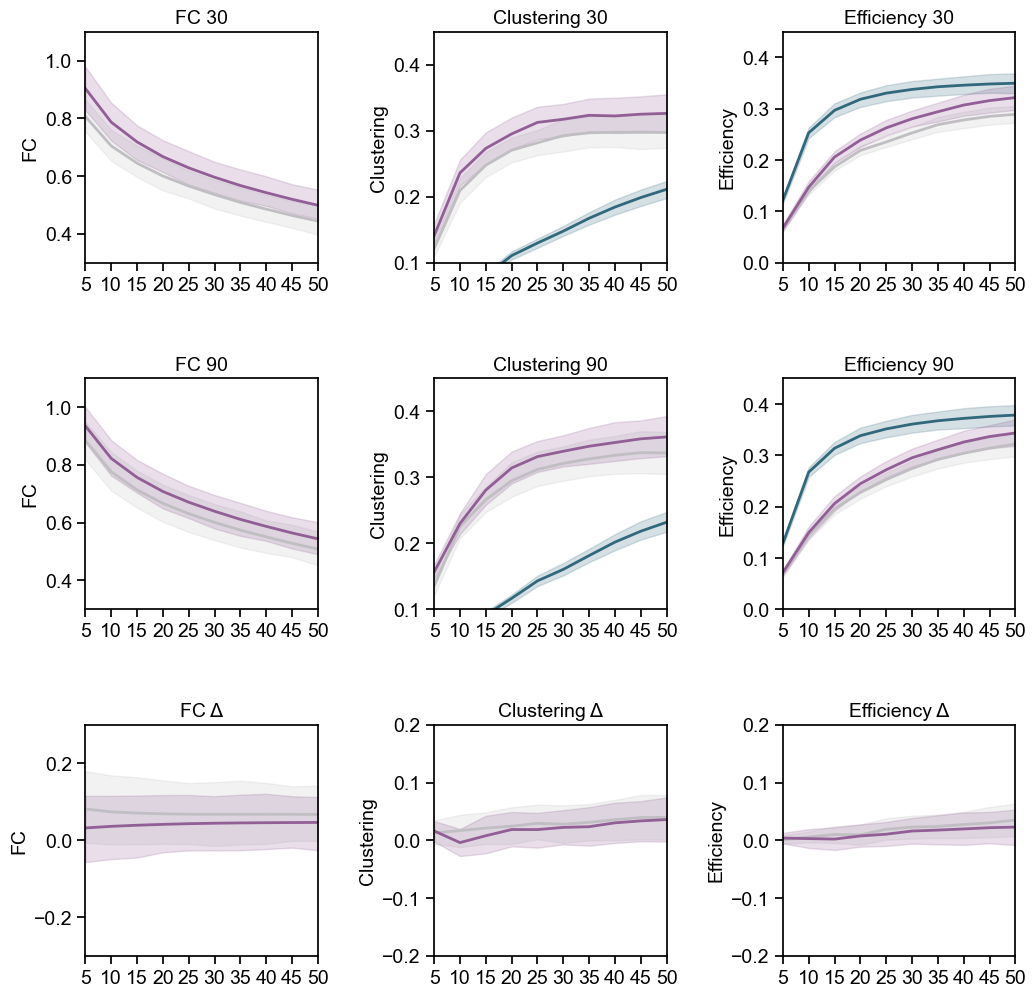

In [32]:
# create plot
plt.figure(figsize=(12, 12))
gs = plt.GridSpec(3, 3)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
textsize=14
linewidth=2

# plotting function
def plot_panel_with_random(data, random_data, sparsity_cols, ax, title, ylabel=None, ylim=None):
    plot_data = data.melt(
        id_vars=['ID', 'Genotype'], 
        value_vars=sparsity_cols,
        var_name='Sparsity',
        value_name='Value'
    )
    plot_data['Sparsity'] = plot_data['Sparsity'].str.split('_').str[1].astype(int)
    
    random_plot_data = random_data.melt(
        id_vars=['ID'],
        value_vars=sparsity_cols,
        var_name='Sparsity',
        value_name='Value'
    )
    random_plot_data['Sparsity'] = random_plot_data['Sparsity'].str.split('_').str[1].astype(int)
    
    sns.lineplot(
        data=random_plot_data,
        x='Sparsity',
        y='Value',
        color='#31687c',
        errorbar=('ci', 95),
        linewidth=linewidth,
        ax=ax,
        legend=False
    )
    
    sns.lineplot(
        data=plot_data[plot_data['Genotype'] == 'WT'],
        x='Sparsity',
        y='Value',
        color='#c0bec2',
        errorbar=('ci', 95),
        linewidth=linewidth,
        ax=ax,
        legend=False
    )
    
    sns.lineplot(
        data=plot_data[plot_data['Genotype'] == 'KO'],
        x='Sparsity',
        y='Value',
        color='#915e95',
        errorbar=('ci', 95),
        linewidth=linewidth,
        ax=ax,
        legend=False
    )
    
    ax.set_title(title, fontsize=textsize)
    ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=textsize)
    if ylim:
        ax.set_ylim(ylim)
    
    ax.set_xlim(5, 50)
    ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    ax.set_xticklabels([5, 10, 15, 20, 25, 30, 35, 40, 45, 50], fontsize=textsize)
    ax.tick_params(axis='y', labelsize=textsize)

def plot_panel(data, sparsity_cols, ax, title, ylabel=None, ylim=None):
    plot_data = data.melt(
        id_vars=['ID', 'Genotype'], 
        value_vars=sparsity_cols,
        var_name='Sparsity',
        value_name='Value'
    )
    plot_data['Sparsity'] = plot_data['Sparsity'].str.split('_').str[1].astype(int)
    
    sns.lineplot(
        data=plot_data[plot_data['Genotype'] == 'WT'],
        x='Sparsity',
        y='Value',
        color='#c0bec2',
        errorbar=('ci', 95),
        linewidth=linewidth,
        ax=ax,
        legend=False
    )
    
    sns.lineplot(
        data=plot_data[plot_data['Genotype'] == 'KO'],
        x='Sparsity',
        y='Value',
        color='#915e95',
        errorbar=('ci', 95),
        linewidth=linewidth,
        ax=ax,
        legend=False
    )
    
    ax.set_title(title, fontsize=textsize)
    ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=textsize)
    if ylim:
        ax.set_ylim(ylim)
    
    ax.set_xlim(5, 50)
    ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    ax.set_xticklabels([5, 10, 15, 20, 25, 30, 35, 40, 45, 50], fontsize=textsize)
    ax.tick_params(axis='y', labelsize=textsize)



ax = plt.subplot(gs[0, 0])
plot_panel(fc_30, fc_30_sparsity_cols, ax, 'FC 30', ylabel='FC', ylim=(0.3, 1.1))

ax = plt.subplot(gs[1, 0])
plot_panel(fc_90, fc_90_sparsity_cols, ax, 'FC 90', ylabel='FC', ylim=(0.3, 1.1))

ax = plt.subplot(gs[2, 0])
plot_panel(fc_delta, fc_delta_sparsity_cols, ax, 'FC Δ', ylabel='FC', ylim=(-0.3, 0.3))

ax = plt.subplot(gs[0, 1])
plot_panel_with_random(clustering_30, rand_clustering_30, clustering_30_sparsity_cols, ax, 'Clustering 30', ylabel='Clustering', ylim=(0.1, 0.45))

ax = plt.subplot(gs[1, 1])
plot_panel_with_random(clustering_90, rand_clustering_90, clustering_90_sparsity_cols, ax, 'Clustering 90', ylabel='Clustering', ylim=(0.1, 0.45))

ax = plt.subplot(gs[2, 1])
plot_panel(cc_delta, cc_delta_sparsity_cols, ax, 'Clustering Δ', ylabel='Clustering', ylim=(-0.2, 0.2))

ax = plt.subplot(gs[0, 2])
plot_panel_with_random(efficiency_30, rand_efficiency_30, efficiency_30_sparsity_cols, ax, 'Efficiency 30', ylabel='Efficiency', ylim=(0, 0.45))

ax = plt.subplot(gs[1, 2])
plot_panel_with_random(efficiency_90, rand_efficiency_90, efficiency_90_sparsity_cols, ax, 'Efficiency 90', ylabel='Efficiency', ylim=(0, 0.45))

ax = plt.subplot(gs[2, 2])
plot_panel(ge_delta, ge_delta_sparsity_cols, ax, 'Efficiency Δ', ylabel='Efficiency', ylim=(-0.2, 0.2))

plt.savefig('/Users/hannalemmik/Dropbox/KO_paper/func/data/graph_theory_plot.pdf')


# stats

In [ ]:
# metadata
gens_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/cohort1_demographics.xlsx'
gens = pd.read_excel(gens_path)
genotype_dict = dict(zip(gens['Animal_ID'], gens['Genotype']))
sex_dict = dict(zip(gens['Animal_ID'], gens['Sex']))
subjects_df = pd.DataFrame({'ID': gens['Animal_ID']})

# make long-format and merge two timepoints for a metric
def make_long_metric(df_30, df_90, subjects_df, genotype_dict, sex_dict):
    long_30 = pd.melt(df_30, id_vars=['ID'], var_name='Sparsity', value_name='PND30')
    long_90 = pd.melt(df_90, id_vars=['ID'], var_name='Sparsity', value_name='PND90')
    combined = pd.merge(subjects_df, long_30, on='ID', how='left')
    combined = pd.merge(combined, long_90, on=['ID', 'Sparsity'], how='left')
    combined['Genotype'] = combined['ID'].map(genotype_dict)
    combined['Sex'] = combined['ID'].map(sex_dict)
    combined.rename(columns={'ID': 'Subject'}, inplace=True)
    return combined

# load network measure data
fc_30_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_fc_PND30.xlsx'
fc_90_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_fc_PND90.xlsx'

clustering_30_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_PND30.xlsx'
clustering_90_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_clustering_PND90.xlsx'

efficiency_30_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_PND30.xlsx'
efficiency_90_path = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/analysis/gt_efficiency_PND90.xlsx'

fc_30 = pd.read_excel(fc_30_path)
fc_90 = pd.read_excel(fc_90_path)
clustering_30 = pd.read_excel(clustering_30_path)
clustering_90 = pd.read_excel(clustering_90_path)
efficiency_30 = pd.read_excel(efficiency_30_path)
efficiency_90 = pd.read_excel(efficiency_90_path)

# reshape and combine 
fc_combined         = make_long_metric(fc_30, fc_90, subjects_df, genotype_dict,sex_dict)
clustering_combined = make_long_metric(clustering_30, clustering_90, subjects_df, genotype_dict,sex_dict)
efficiency_combined = make_long_metric(efficiency_30, efficiency_90, subjects_df, genotype_dict,sex_dict)

# check
fc_combined.head(2)

,Subject,Sparsity,PND30,PND90,Genotype,Sex
0,COMR202c,Sparsity_5,0.826528,0.913133,KO,F
1,COMR202c,Sparsity_10,0.716593,0.814730,KO,F


In [64]:
def add_change_col(df):
    # subtract pnd30 from pnd90 to get change per row
    df['change'] = df['PND90'] - df['PND30']
    return df

# list of metric names and already created combined dataframes in order
metric_names = ['fc', 'cc', 'ge']
combined_dict = {
    'fc': fc_combined,
    'cc': clustering_combined,
    'ge': efficiency_combined
}
wide_tables = {}

for metric in metric_names:
    df = combined_dict[metric]
    # add the change column
    df = add_change_col(df)
    # for each timepoint and change, make a wide-format version and store it
    for suffix in ['PND30', 'PND90', 'change']:

        wide = df.pivot_table(
            index=['Subject', 'Genotype', 'Sex'],  
            columns='Sparsity',
            values=suffix.lower() if suffix == 'change' else suffix
        ).rename_axis(columns=None).reset_index()

        wide_tables[f'{metric}{suffix.lower()}_wide'] = wide

#just in case
fc30_wide = wide_tables['fcpnd30_wide']
fc30_wide.head(1)


,Subject,Genotype,Sex,Sparsity_10,Sparsity_15,Sparsity_20,Sparsity_25,Sparsity_30,Sparsity_35,Sparsity_40,Sparsity_45,Sparsity_5,Sparsity_50
0,COMR194a,KO,M,0.951254,0.853511,0.786236,0.73803,0.698295,0.662107,0.63159,0.603033,1.106184,0.57763


In [66]:
sparsity_columns = ['Sparsity_5', 'Sparsity_10', 'Sparsity_15', 'Sparsity_20', 'Sparsity_25', 
                    'Sparsity_30', 'Sparsity_35', 'Sparsity_40', 'Sparsity_45', 'Sparsity_50']
sorted_sparsity_columns = sorted(sparsity_columns, key=lambda col: int(col.split('_')[1]))

x_values = np.array([int(col.split('_')[1]) for col in sorted_sparsity_columns])

# add auc column to all dataframes in wide_tables
for k, df in wide_tables.items():
    # apply np.trapz for this rowwise 
    df['AUC'] = df[sorted_sparsity_columns].apply(lambda row: np.trapz(row, x=x_values), axis=1)


In [67]:
n_iterations = 10000
all_results = {}

# define the specific pairs to compare
desired_pairs = [
    ("M_KO", "M_WT"),
    ("M_KO", "F_KO"),
    ("M_WT", "F_WT"),
    ("F_KO", "F_WT")
]

for k, df in wide_tables.items():
    # make the group column, label format should match the pairs defined above
    df['Sex_Genotype'] = df['Sex'] + '_' + df['Genotype']
    # determine which pairs are present in this data
    observed_groups = df['Sex_Genotype'].unique()
    filtered_pairs = [pair for pair in desired_pairs if pair[0] in observed_groups and pair[1] in observed_groups]
    
    # compute observed mean diff for each pair
    original_diffs = {}
    for group1, group2 in filtered_pairs:
        m1 = df[df['Sex_Genotype'] == group1]['AUC'].mean()
        m2 = df[df['Sex_Genotype'] == group2]['AUC'].mean()
        original_diffs[(group1, group2)] = m1 - m2

    # permutation results for each pair
    permutation_diffs = {pair: [] for pair in filtered_pairs}

    for i in range(n_iterations):
        shuffled_labels = np.random.permutation(df['Sex_Genotype'])
        shuffled_df = df.copy()
        shuffled_df['Sex_Genotype'] = shuffled_labels
        means = shuffled_df.groupby('Sex_Genotype')['AUC'].mean()
        for group1, group2 in filtered_pairs:
            permuted_diff = means[group1] - means[group2]
            permutation_diffs[(group1, group2)].append(permuted_diff)
    # calculate p-values
    p_values = {}
    for pair in filtered_pairs:
        permuted = np.array(permutation_diffs[pair])
        # drop nan for permutation
        permuted = permuted[~np.isnan(permuted)]
        original = original_diffs[pair]
        p = np.mean(np.abs(permuted) >= np.abs(original))
        p_values[pair] = p

    # corrects for the number of comparisons within a specific set of p-values passed to multipletests, 
    # that is, per single sheet (e.g., for all pairwise group comparisons within fc30, ge30, etc.)
    p_values_list = list(p_values.values())
    if p_values_list:  # if there is at least one comparison to make
        corrected = multipletests(p_values_list, method='bonferroni')[1]
        corrected_dict = {pair: cp for pair, cp in zip(filtered_pairs, corrected)}
    else:
        corrected_dict = {}

    all_results[k] = {
        'original_diffs': original_diffs,
        'corrected_p_values': corrected_dict
    }


In [68]:
all_results

{'fcpnd30_wide': {'original_diffs': {('M_KO', 'M_WT'): 3.6004132957065558,
   ('M_KO', 'F_KO'): 2.04845844424241,
   ('M_WT', 'F_WT'): 0.4937612840179746,
   ('F_KO', 'F_WT'): 2.0457161354821203},
  'corrected_p_values': {('M_KO', 'M_WT'): 0.6328,
   ('M_KO', 'F_KO'): 1.0,
   ('M_WT', 'F_WT'): 1.0,
   ('F_KO', 'F_WT'): 1.0}},
 'fcpnd90_wide': {'original_diffs': {('M_KO', 'M_WT'): 1.7077067458573225,
   ('M_KO', 'F_KO'): 2.5917334955645046,
   ('M_WT', 'F_WT'): 2.762690243458149,
   ('F_KO', 'F_WT'): 1.8786634937509668},
  'corrected_p_values': {('M_KO', 'M_WT'): 1.0,
   ('M_KO', 'F_KO'): 1.0,
   ('M_WT', 'F_WT'): 1.0,
   ('F_KO', 'F_WT'): 1.0}},
 'fcchange_wide': {'original_diffs': {('M_KO', 'M_WT'): -2.343514908422125,
   ('M_KO', 'F_KO'): 0.18455598086901204,
   ('M_WT', 'F_WT'): 2.250804371356379,
   ('F_KO', 'F_WT'): -0.27726651793475776},
  'corrected_p_values': {('M_KO', 'M_WT'): 1.0,
   ('M_KO', 'F_KO'): 1.0,
   ('M_WT', 'F_WT'): 1.0,
   ('F_KO', 'F_WT'): 1.0}},
 'ccpnd30_wide':

In [ ]:
n_iterations = 10000
genotype_results = {}

for k, df in wide_tables.items():
    # ensure genotype is string
    df['Genotype'] = df['Genotype'].astype(str)

    # calculate observed mean auc for ko and wt
    mean_ko = df[df['Genotype'] == 'KO']['AUC'].mean()
    mean_wt = df[df['Genotype'] == 'WT']['AUC'].mean()
    observed_diff = mean_ko - mean_wt

    # permutation differences
    perm_diffs = []
    for _ in range(n_iterations):
        shuffled_genotype = np.random.permutation(df['Genotype'])
        shuffled_df = df.copy()
        shuffled_df['Genotype'] = shuffled_genotype
        mean_ko_perm = shuffled_df[shuffled_df['Genotype'] == 'KO']['AUC'].mean()
        mean_wt_perm = shuffled_df[shuffled_df['Genotype'] == 'WT']['AUC'].mean()
        perm_diffs.append(mean_ko_perm - mean_wt_perm)

    perm_diffs = np.array(perm_diffs)
    p = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    # multiplicity correction: multiply by 3 since three tests per timepoint, cap at 1.0
    corrected_p = min(p * 3, 1.0)

    genotype_results[k] = {
        'observed_diff': observed_diff,
        'corrected_p_value': corrected_p
    }



table: fcpnd30_wide
genotype comparison: KO vs WT
auc difference: 2.966523408485056
corrected p-value (x3): 0.2997

table: fcpnd90_wide
genotype comparison: KO vs WT
auc difference: 2.010681254048876
corrected p-value (x3): 0.9819

table: fcchange_wide
genotype comparison: KO vs WT
auc difference: -1.2264337726933296
corrected p-value (x3): 1.0

table: ccpnd30_wide
genotype comparison: KO vs WT
auc difference: 1.1753106440405716
corrected p-value (x3): 0.30300000000000005

table: ccpnd90_wide
genotype comparison: KO vs WT
auc difference: 1.00504790973236
corrected p-value (x3): 0.6003000000000001

table: ccchange_wide
genotype comparison: KO vs WT
auc difference: -0.37632192054067126
corrected p-value (x3): 1.0

table: gepnd30_wide
genotype comparison: KO vs WT
auc difference: 1.0155124943416602
corrected p-value (x3): 0.0453

table: gepnd90_wide
genotype comparison: KO vs WT
auc difference: 0.861754288753243
corrected p-value (x3): 0.2841

table: gechange_wide
genotype comparison: KO 

In [ ]:
# print results
for t, res in genotype_results.items():
    print(f'table: {t}')
    print(f'genotype comparison: KO vs WT')
    print(f'auc difference: {res["observed_diff"]}')
    print(f'corrected p-value: {res["corrected_p_value"]}\n')